<a href="https://colab.research.google.com/github/Hussien-Sayed/Monthly-Insurance-Claim-Prediction/blob/main/Monthly_Insurance_Claim_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2><center> Monthly-Insurance-Claim-Prediction</h2></center>

*About the problem*:

Short-term insurance claims are one of the largest costs in the insurance industry, and are extremely difficult to forecast. Zimnat Insurance wants to predict the value of future claims per client, in order to better forecast annual costs.

*The objective of this challenge is*:

To create a machine learning model to predict how much a client will claim from Zimnat per month for a whole year.

The solution will aid Zimnat in being better prepared to address claims that are submitted, and improve customer satisfaction by alerting clients to possible claims they will make in the future.



## Table of contents:

1. [Importing libraries](#Libraries)
2. [Loading data](#Data)
3. [Statistical summaries](#Statistics)
4. [Missing values and duplicates](#Missing)
5. [Outliers](#Outliers)
6. [Dataset datatypes](#Datatypes)
7. [Feature engineering](#Engineering)
8. [Date features EDA](#Dates)
9. [Branch features EDA](#Branch)
10. [Categorical features](#Categorical)
11. [Preprocess test dataset](#Preprocess)
12. [Modelling](#Modelling)
13. [Submission](#Submission)


<a name="Libraries"></a>
## 1. Importing libraries


In [1]:
!pip install catboost

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold, KFold,cross_val_predict,cross_val_score,cross_validate

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
pd.options.display.float_format = '{:.5f}'.format

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


<a name="Data"></a>
## 2. Loading data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = "/content/drive/MyDrive/zindi/UmojaHack2022/"

In [5]:
# Load files
train = pd.read_csv(path+'train.csv')
policies = pd.read_csv(path+'policies.csv')
test = pd.read_csv(path+'test.csv')
samplesubmission = pd.read_csv(path+'SampleSubmission.csv')

# Preview train dataset
train.head()

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch,target
0,ID_JZ7QWRHH57RO,pol000009680,claim0011359,300000.00000,prod00027,ag00068,cob00031,rt00006,2021-05-13,ct0003,rf0001,pc0007,sc00022,br00006,82150.00000
1,ID_KQ5TJMVLJ4EP,pol000006869,claim0005272,16000.00000,prod00005,ag00226,cob00010,rt00032,2018-05-13,ct0003,rf0001,pc0007,sc00023,br00002,3780.24000
2,ID_NYHI7WJGGIAE,pol000006135,claim0004147,3000.00000,prod00029,ag00037,cob00010,rt00026,2018-08-18,ct0003,rf0001,pc0007,sc00024,br00002,2196.50000
3,ID_ROMMDCXYUXN5,pol000008991,claim0009962,6000.00000,prod00005,ag00037,cob00009,rt00032,2018-12-20,ct0003,rf0001,pc0007,sc00021,br00001,105.67000
4,ID_2OTD9NX8L73D,pol000007768,claim0007346,26850.00000,prod00015,ag00226,cob00034,rt00023,2018-11-07,ct0001,rf0001,pc0007,sc00021,br00001,1605.64000


In [6]:
# Preview policies dataset
policies.head()

,policy_number,product_code,trans_date,from_date,to_date,agent,class_of_business,client_type,renewal_frequency,branch
0,pol000006995,prod00033,2017-07-01 08:24:55.800,2017-07-01 00:00:00.000,2018-07-01 00:00:00.000,ag00005,cob00035,ct0001,rf0002,br00002
1,pol000009828,prod00005,2017-07-01 09:04:02.217,2017-07-03 00:00:00.000,2017-11-02 00:00:00.000,ag00226,cob00009,ct0003,rf0001,br00006
2,pol000009828,prod00005,2017-07-01 09:04:02.217,2017-07-03 00:00:00.000,2017-11-02 00:00:00.000,ag00226,cob00031,ct0003,rf0001,br00006
3,pol000007729,prod00005,2017-07-01 09:36:53.843,2017-07-01 00:00:00.000,2017-10-31 00:00:00.000,ag00005,cob00031,ct0003,rf0001,br00002
4,pol000007729,prod00005,2017-07-01 09:36:53.843,2017-07-01 00:00:00.000,2017-10-31 00:00:00.000,ag00005,cob00009,ct0003,rf0001,br00002


In [7]:
policies.columns.difference(train.columns)

Index(['from_date', 'product_code', 'to_date', 'trans_date'], dtype='object')

In [8]:
train.columns.difference(policies.columns)

Index(['claim_id', 'claim_number', 'loss_date', 'primary_cause', 'product',
       'risk_type', 'secondary_cause', 'sum_insured', 'target'],
      dtype='object')

In [9]:
#policy_number is bestto be used to join/mix

In [10]:
len(policies.agent.unique()),len(train.agent.unique())

(223, 8)

In [11]:
len(policies.policy_number.unique()),len(train.policy_number.unique())

(5217, 4077)

In [12]:
# Preview test dataset
test.head()

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch
0,ID_4RO0KZI9BBW2,pol000007115,claim0005757,300000.00000,prod00005,ag00068,cob00009,rt00032,2021-03-11,ct0003,rf0001,pc0007,sc00029,br00004
1,ID_GTE9ZUJ9GZ97,pol000006008,claim0003037,2700000.00000,prod00015,ag00064,cob00034,rt00023,2020-06-25,ct0001,rf0003,pc0007,sc00022,br00002
2,ID_RUVIYRKWZ4RG,pol000007651,claim0006507,4071352.00000,prod00012,ag00021,cob00016,rt00015,2019-03-14,ct0001,rf0001,pc0011,sc00049,br00001
3,ID_J81X8SWU6JYN,pol000010981,claim0013636,0.00000,prod00002,ag00037,cob00002,rt00002,2018-12-04,ct0001,rf0002,pc0002,sc00012,br00005
4,ID_94NM3JJAWWOQ,pol000005926,claim0001750,1607178.00000,prod00015,ag00037,cob00034,rt00023,2019-09-18,ct0001,rf0003,pc0007,sc00022,br00002


In [13]:
# Preview sample submission file
samplesubmission.head()

,claim_id,target
0,ID_4RO0KZI9BBW2,0
1,ID_GTE9ZUJ9GZ97,0
2,ID_RUVIYRKWZ4RG,0
3,ID_J81X8SWU6JYN,0
4,ID_94NM3JJAWWOQ,0


In [14]:
# Check size and shape of datasets
train.shape, policies.shape, test.shape, samplesubmission.shape

((9376, 15), (30371, 10), (4019, 14), (4019, 2))

<a name="Statistics"></a>
## 3. Statistical summaries

In [15]:
# Train statistical summary
train.describe(include = 'all')

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch,target
count,9376,9290,9376,9376.00000,9376,9376,9376,9376,9376,9376,9376,9376,9376,9376,9376.00000
unique,9376,4076,9167,NaN,37,8,37,50,1359,3,5,21,74,11,NaN
top,ID_JZ7QWRHH57RO,pol000006026,claim0001351,NaN,prod00015,ag00037,cob00034,rt00023,2019-08-20,ct0001,rf0002,pc0007,sc00023,br00002,NaN
freq,1,254,3,NaN,4411,3114,3608,3771,83,6096,4853,7396,2980,3900,NaN
mean,NaN,NaN,NaN,8534789.61723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41464.71125
std,NaN,NaN,NaN,112556487.28996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208434.71755
min,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
25%,NaN,NaN,NaN,6500.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,287.92500
50%,NaN,NaN,NaN,50542.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1956.92500
75%,NaN,NaN,NaN,420000.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12700.64250


From the above statistical summary, we can deduce some of the following insights:
 - The minimum amount claimed is 0 and the maximum is 7868590.62000
 - There are 11 different branches
 - Majority of the training features are categorical in nature

In [16]:
# Policies statistical summary
policies.describe(include = 'all')

,policy_number,product_code,trans_date,from_date,to_date,agent,class_of_business,client_type,renewal_frequency,branch
count,30371,30371,30371,30371,30371,30371,30325,30371,30371,30371
unique,5217,37,20836,1431,1369,223,37,3,5,11
top,pol000005951,prod00005,2020-07-01 08:45:55.653,2018-02-01 00:00:00.000,2019-01-31 00:00:00.000,ag00226,cob00031,ct0001,rf0001,br00002
freq,174,9994,14,1122,1463,4620,7755,16747,14184,13636


<a name="Missing"></a>
## 4. Missing values and duplicates

In [17]:
train.isnull().sum()/len(train), test.isnull().sum()/len(test), policies.isnull().sum()/len(policies)

(claim_id            0.00000
 policy_number       0.00917
 claim_number        0.00000
 sum_insured         0.00000
 product             0.00000
 agent               0.00000
 class_of_business   0.00000
 risk_type           0.00000
 loss_date           0.00000
 client_type         0.00000
 renewal_frequency   0.00000
 primary_cause       0.00000
 secondary_cause     0.00000
 branch              0.00000
 target              0.00000
 dtype: float64,
 claim_id            0.00000
 policy_number       0.01020
 claim_number        0.00000
 sum_insured         0.00000
 product             0.00000
 agent               0.00000
 class_of_business   0.00000
 risk_type           0.00000
 loss_date           0.00000
 client_type         0.00000
 renewal_frequency   0.00000
 primary_cause       0.00000
 secondary_cause     0.00000
 branch              0.00000
 dtype: float64,
 policy_number       0.00000
 product_code        0.00000
 trans_date          0.00000
 from_date           0.00000
 to_date 

In [18]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any(), policies.duplicated().any()

(False, False, False)

<a name="Outliers"></a>
## 5. Outliers

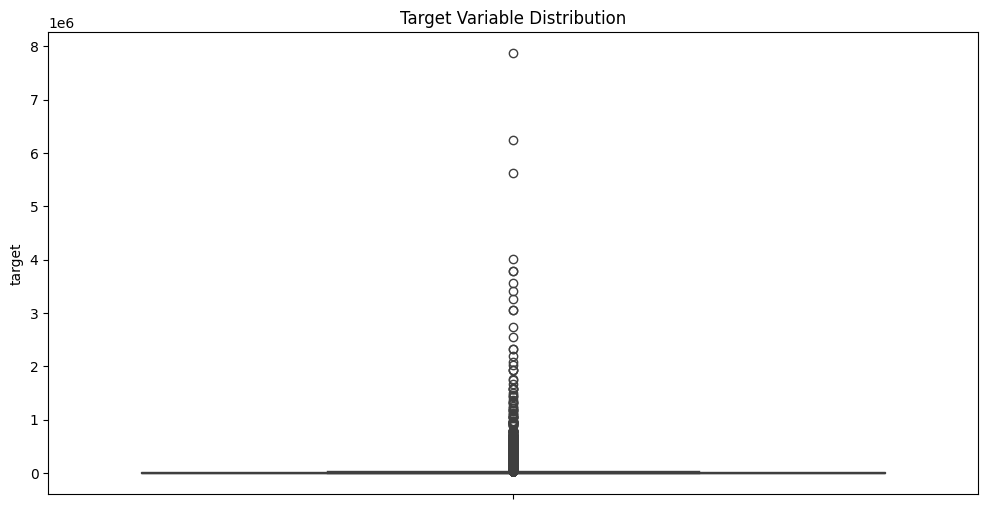

In [19]:
# A box plot showing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(train.target)
plt.title('Target Variable Distribution');

<a name="Datatypes"></a>
## 6. Dataset datatypes

In [20]:
# Train dataset datatypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9376 entries, 0 to 9375
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   claim_id           9376 non-null   object 
 1   policy_number      9290 non-null   object 
 2   claim_number       9376 non-null   object 
 3   sum_insured        9376 non-null   float64
 4   product            9376 non-null   object 
 5   agent              9376 non-null   object 
 6   class_of_business  9376 non-null   object 
 7   risk_type          9376 non-null   object 
 8   loss_date          9376 non-null   object 
 9   client_type        9376 non-null   object 
 10  renewal_frequency  9376 non-null   object 
 11  primary_cause      9376 non-null   object 
 12  secondary_cause    9376 non-null   object 
 13  branch             9376 non-null   object 
 14  target             9376 non-null   float64
dtypes: float64(2), object(13)
memory usage: 1.1+ MB


In [21]:
# Convert datetime variables to datetime objects
train.loss_date = pd.to_datetime(train.loss_date, errors='coerce')

# Confirm that the dates have been converted successfully
train.loss_date.describe()

,loss_date
count,9376
mean,2019-05-28 07:56:52.627986176
min,2018-01-01 00:00:00
25%,2018-07-10 18:00:00
50%,2019-02-11 00:00:00
75%,2020-02-15 00:00:00
max,2021-10-22 00:00:00


In [22]:
# Convert categorical variables to categorical objects
cat_cols = train.columns.difference(['claim_id', 'loss_date', 'sum_insured', 'target']).tolist()

# Preview categorical variables
train[cat_cols].head()

,agent,branch,claim_number,class_of_business,client_type,policy_number,primary_cause,product,renewal_frequency,risk_type,secondary_cause
0,ag00068,br00006,claim0011359,cob00031,ct0003,pol000009680,pc0007,prod00027,rf0001,rt00006,sc00022
1,ag00226,br00002,claim0005272,cob00010,ct0003,pol000006869,pc0007,prod00005,rf0001,rt00032,sc00023
2,ag00037,br00002,claim0004147,cob00010,ct0003,pol000006135,pc0007,prod00029,rf0001,rt00026,sc00024
3,ag00037,br00001,claim0009962,cob00009,ct0003,pol000008991,pc0007,prod00005,rf0001,rt00032,sc00021
4,ag00226,br00001,claim0007346,cob00034,ct0001,pol000007768,pc0007,prod00015,rf0001,rt00023,sc00021


In [23]:
# Fill in missing values in categorical variables with the most common
train[cat_cols] = train[cat_cols].apply(lambda x: x.fillna(x.value_counts().index[0]))

# Convert
for col in cat_cols:
  train[col] = train[col].astype('category')

# Confirm
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9376 entries, 0 to 9375
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   claim_id           9376 non-null   object        
 1   policy_number      9376 non-null   category      
 2   claim_number       9376 non-null   category      
 3   sum_insured        9376 non-null   float64       
 4   product            9376 non-null   category      
 5   agent              9376 non-null   category      
 6   class_of_business  9376 non-null   category      
 7   risk_type          9376 non-null   category      
 8   loss_date          9376 non-null   datetime64[ns]
 9   client_type        9376 non-null   category      
 10  renewal_frequency  9376 non-null   category      
 11  primary_cause      9376 non-null   category      
 12  secondary_cause    9376 non-null   category      
 13  branch             9376 non-null   category      
 14  target  

<a name="Engineering"></a>
## 7. Feature engineering

In [24]:
# Extract day, month and year from the loss date column
# day
train['loss_date_day'] = train.loss_date.dt.day

# month
train['loss_date_month'] = train.loss_date.dt.month

# year
train['loss_date_year'] = train.loss_date.dt.year

# Preview engineered date features
train[['loss_date', 'loss_date_day', 'loss_date_month', 'loss_date_year']].head()

,loss_date,loss_date_day,loss_date_month,loss_date_year
0,2021-05-13,13,5,2021
1,2018-05-13,13,5,2018
2,2018-08-18,18,8,2018
3,2018-12-20,20,12,2018
4,2018-11-07,7,11,2018


<a name="Dates"></a>
## 8. Date features EDA

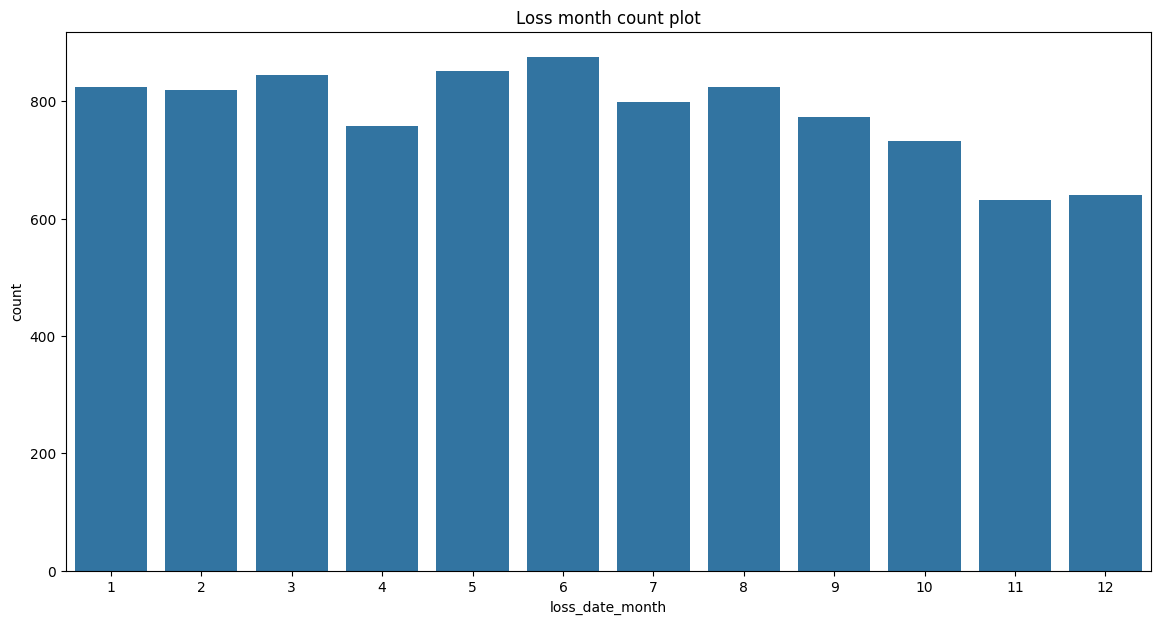

In [25]:
# Loss month countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'loss_date_month', data = train)
plt.title('Loss month count plot')
plt.show()

- June has the highest number of claims and December has the least number of claims

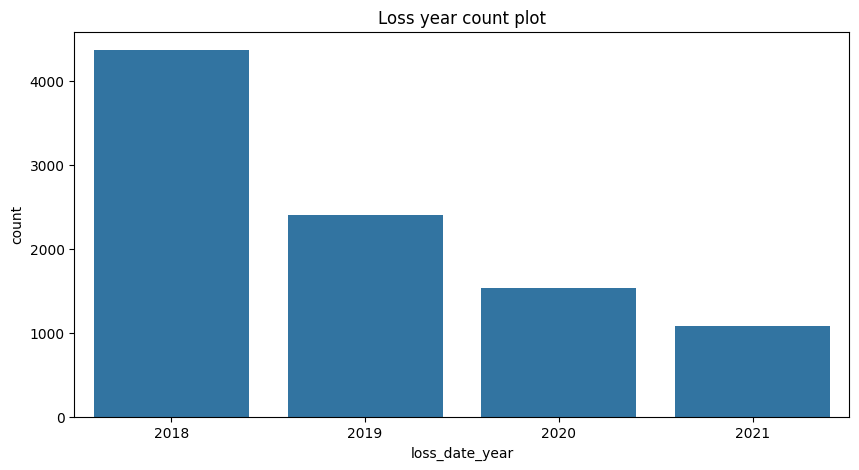

In [26]:
# Loss year countplot
plt.figure(figsize = (10, 5))
sns.countplot(x = 'loss_date_year', data = train)
plt.title('Loss year count plot')
plt.show()

- Most of the claims were done in the year 2018 and the least in the year 2021

<a name="Branch"></a>
## 9. Branch features EDA

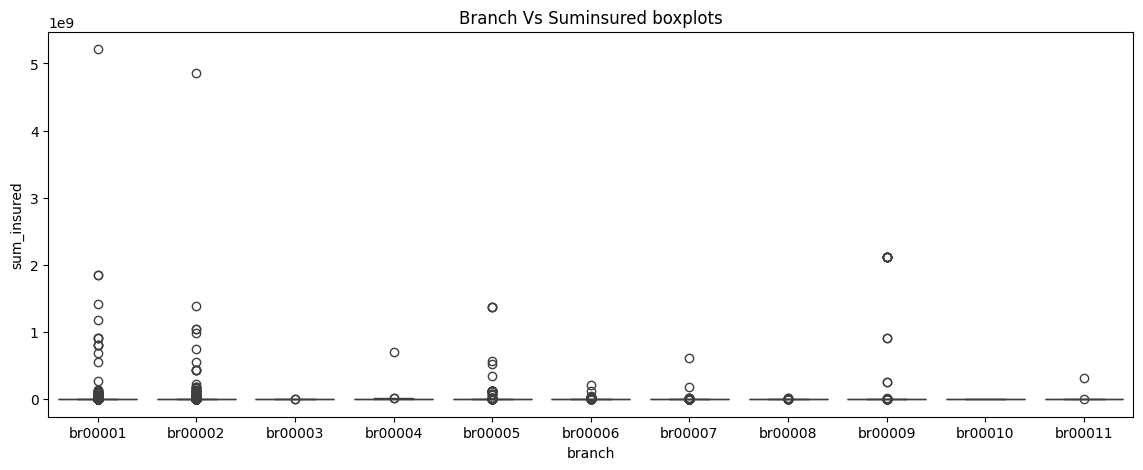

In [27]:
plt.figure(figsize = (14, 5))
sns.boxplot(x = 'branch', y = 'sum_insured', data = train)
plt.title('Branch Vs Suminsured boxplots')
plt.show()

- Branch 1 and 2 seem to have the highest number of outliers in the sum insured variable.

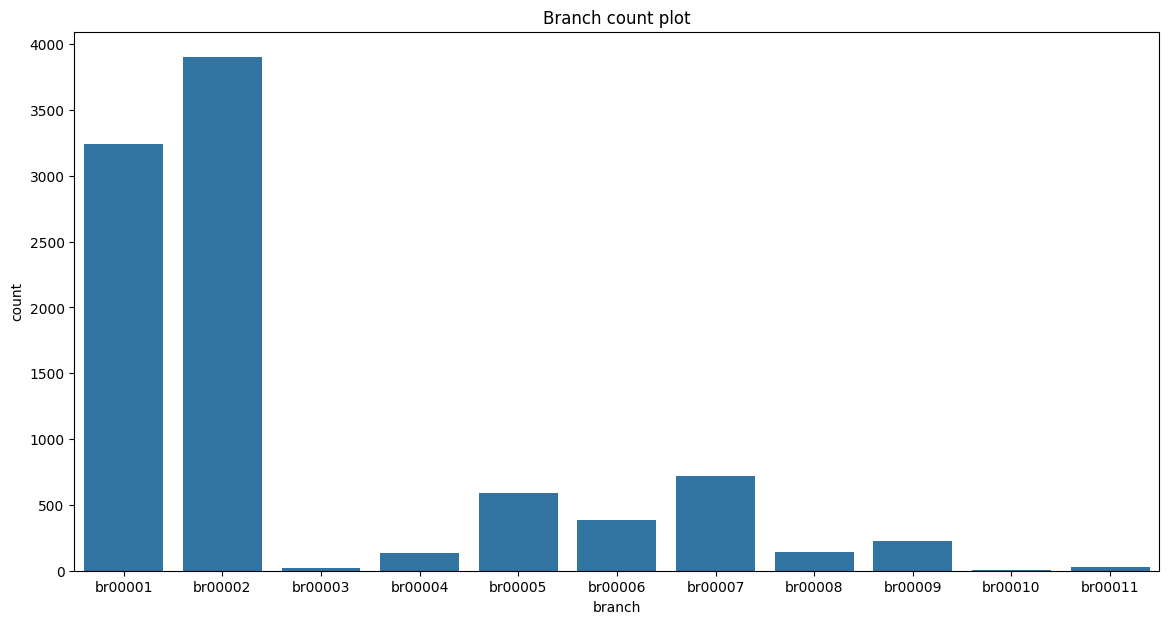

In [28]:
# Branch countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'branch', data = train)
plt.title('Branch count plot')
plt.show()

 - Most of the claims are concentrated in branch1 and branch2,

<a name="Categorical"></a>
## 10. Categorical features


In [29]:
# Label encode categorical variables
for col in cat_cols:
  # Instantiate Labelencoder
  le = LabelEncoder()
  train[col] = le.fit_transform(train[col])

# Preview engineered train dataset
train.head()

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch,target,loss_date_day,loss_date_month,loss_date_year
0,ID_JZ7QWRHH57RO,3070,7439,300000.00000,26,4,30,5,2021-05-13,2,0,6,20,5,82150.00000,13,5,2021
1,ID_KQ5TJMVLJ4EP,1126,3469,16000.00000,4,7,9,31,2018-05-13,2,0,6,21,1,3780.24000,13,5,2018
2,ID_NYHI7WJGGIAE,630,2799,3000.00000,28,1,9,25,2018-08-18,2,0,6,22,1,2196.50000,18,8,2018
3,ID_ROMMDCXYUXN5,2546,6448,6000.00000,4,1,8,31,2018-12-20,2,0,6,19,0,105.67000,20,12,2018
4,ID_2OTD9NX8L73D,1767,4832,26850.00000,14,7,32,22,2018-11-07,0,0,6,19,0,1605.64000,7,11,2018


<a name="Preprocess"></a>
## 11.  Preprocess test dataset

In [30]:
# Convert datetime variables to datetime objects
test.loss_date = pd.to_datetime(test.loss_date, errors='coerce')

# Fill in missing values in categorical variables with the most common
test[cat_cols] = test[cat_cols].apply(lambda x: x.fillna(x.value_counts().index[0]))

# Convert
for col in cat_cols:
  test[col] = test[col].astype('category')

# Extract day, month and year from the loss date column
test['loss_date_day'] = test.loss_date.dt.day #day

test['loss_date_month'] = test.loss_date.dt.month #month

test['loss_date_year'] = test.loss_date.dt.year #year

# Label encode categorical variables
for col in cat_cols:
  # Instantiate Labelencoder
  le = LabelEncoder()
  test[col] = le.fit_transform(test[col])

# Preview engineered test dataset
test.head()

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch,loss_date_day,loss_date_month,loss_date_year
0,ID_4RO0KZI9BBW2,739,1667,300000.00000,4,4,8,29,2021-03-11,2,0,6,26,3,11,3,2021
1,ID_GTE9ZUJ9GZ97,312,883,2700000.00000,12,3,28,20,2020-06-25,0,2,6,20,1,25,6,2020
2,ID_RUVIYRKWZ4RG,917,1895,4071352.00000,10,0,14,14,2019-03-14,0,0,9,43,0,14,3,2019
3,ID_J81X8SWU6JYN,2081,3852,0.00000,1,1,1,1,2018-12-04,0,1,1,10,4,4,12,2018
4,ID_94NM3JJAWWOQ,257,507,1607178.00000,12,1,28,20,2019-09-18,0,2,6,20,1,18,9,2019


<a name="Modelling"></a>
## 12. Modelling

### Simple Linear regression Model

In [31]:
# Select main columns to be used in training
main_cols = train.columns.difference(['claim_id', 'loss_date', 'target']).tolist()
X = train[main_cols]
y = train.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Check the MAE score of the model
print(f'LinearRegression MAE score on the X_test is: {mean_absolute_error(y_test, y_pred)}')

LinearRegression MAE score on the X_test is: 58703.29737447141


### Catbbost Model

In [6]:
# reLoad files
train = pd.read_csv(path+'train.csv')
policies = pd.read_csv(path+'policies.csv')
test = pd.read_csv(path+'test.csv')
samplesubmission = pd.read_csv(path+'SampleSubmission.csv')

# put them in the format X,y,test_ix
taget_col=['target']
X_cols = train.columns.difference(taget_col)

X = pd.concat((train[X_cols],(test[X_cols])))
y= train[taget_col].copy()
test_ix = len(train)

# Preview train dataset
print(X.shape,y.shape,test_ix)
X.head()

(13395, 14) (9376, 1) 9376


,agent,branch,claim_id,claim_number,class_of_business,client_type,loss_date,policy_number,primary_cause,product,renewal_frequency,risk_type,secondary_cause,sum_insured
0,ag00068,br00006,ID_JZ7QWRHH57RO,claim0011359,cob00031,ct0003,2021-05-13,pol000009680,pc0007,prod00027,rf0001,rt00006,sc00022,300000.00000
1,ag00226,br00002,ID_KQ5TJMVLJ4EP,claim0005272,cob00010,ct0003,2018-05-13,pol000006869,pc0007,prod00005,rf0001,rt00032,sc00023,16000.00000
2,ag00037,br00002,ID_NYHI7WJGGIAE,claim0004147,cob00010,ct0003,2018-08-18,pol000006135,pc0007,prod00029,rf0001,rt00026,sc00024,3000.00000
3,ag00037,br00001,ID_ROMMDCXYUXN5,claim0009962,cob00009,ct0003,2018-12-20,pol000008991,pc0007,prod00005,rf0001,rt00032,sc00021,6000.00000
4,ag00226,br00001,ID_2OTD9NX8L73D,claim0007346,cob00034,ct0001,2018-11-07,pol000007768,pc0007,prod00015,rf0001,rt00023,sc00021,26850.00000


In [7]:
# Convert datetime variables to datetime objects
X.loss_date = pd.to_datetime(X.loss_date, errors='coerce')

# Confirm that the dates have been converted successfully
X.loss_date.describe()

,loss_date
count,13395
mean,2019-05-28 23:58:23.247480320
min,2018-01-01 00:00:00
25%,2018-07-14 00:00:00
50%,2019-02-12 00:00:00
75%,2020-02-20 00:00:00
max,2021-10-26 00:00:00


In [8]:
# Convert categorical variables to categorical objects
cat_cols = X.columns.difference(['claim_id', 'loss_date', 'sum_insured', 'target']).tolist()

# Preview categorical variables
X[cat_cols].head()

,agent,branch,claim_number,class_of_business,client_type,policy_number,primary_cause,product,renewal_frequency,risk_type,secondary_cause
0,ag00068,br00006,claim0011359,cob00031,ct0003,pol000009680,pc0007,prod00027,rf0001,rt00006,sc00022
1,ag00226,br00002,claim0005272,cob00010,ct0003,pol000006869,pc0007,prod00005,rf0001,rt00032,sc00023
2,ag00037,br00002,claim0004147,cob00010,ct0003,pol000006135,pc0007,prod00029,rf0001,rt00026,sc00024
3,ag00037,br00001,claim0009962,cob00009,ct0003,pol000008991,pc0007,prod00005,rf0001,rt00032,sc00021
4,ag00226,br00001,claim0007346,cob00034,ct0001,pol000007768,pc0007,prod00015,rf0001,rt00023,sc00021


In [9]:
# Fill in missing values in categorical variables with the most common
X[cat_cols] = X[cat_cols].apply(lambda x: x.fillna(x.value_counts().index[0]))

# Convert
for col in cat_cols:
  X[col] = X[col].astype('category')

# Confirm
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13395 entries, 0 to 4018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   agent              13395 non-null  category      
 1   branch             13395 non-null  category      
 2   claim_id           13395 non-null  object        
 3   claim_number       13395 non-null  category      
 4   class_of_business  13395 non-null  category      
 5   client_type        13395 non-null  category      
 6   loss_date          13395 non-null  datetime64[ns]
 7   policy_number      13395 non-null  category      
 8   primary_cause      13395 non-null  category      
 9   product            13395 non-null  category      
 10  renewal_frequency  13395 non-null  category      
 11  risk_type          13395 non-null  category      
 12  secondary_cause    13395 non-null  category      
 13  sum_insured        13395 non-null  float64       
dtypes: category(

In [10]:
# Extract day, month and year from the loss date column
# day
X['loss_date_day'] = X.loss_date.dt.day

# month
X['loss_date_month'] = X.loss_date.dt.month

# year
X['loss_date_year'] = X.loss_date.dt.year

# Preview engineered date features
X[['loss_date', 'loss_date_day', 'loss_date_month', 'loss_date_year']].head()

,loss_date,loss_date_day,loss_date_month,loss_date_year
0,2021-05-13,13,5,2021
1,2018-05-13,13,5,2018
2,2018-08-18,18,8,2018
3,2018-12-20,20,12,2018
4,2018-11-07,7,11,2018


In [11]:
# Label encode categorical variables
for col in cat_cols:
  # Instantiate Labelencoder
  le = LabelEncoder()
  X[col] = le.fit_transform(X[col])

# Preview engineered train dataset
X.head()

,agent,branch,claim_id,claim_number,class_of_business,client_type,loss_date,policy_number,primary_cause,product,renewal_frequency,risk_type,secondary_cause,sum_insured,loss_date_day,loss_date_month,loss_date_year
0,4,5,ID_JZ7QWRHH57RO,10480,30,2,2021-05-13,3881,6,26,0,5,20,300000.00000,13,5,2021
1,7,1,ID_KQ5TJMVLJ4EP,4908,9,2,2018-05-13,1381,6,4,0,31,21,16000.00000,13,5,2018
2,1,1,ID_NYHI7WJGGIAE,3968,9,2,2018-08-18,761,6,28,0,25,22,3000.00000,18,8,2018
3,1,0,ID_ROMMDCXYUXN5,9129,8,2,2018-12-20,3213,6,4,0,31,19,6000.00000,20,12,2018
4,7,0,ID_2OTD9NX8L73D,6856,32,0,2018-11-07,2218,6,14,0,22,19,26850.00000,7,11,2018


In [12]:
# Modeling
main_cols = X.columns.difference(['claim_id', 'loss_date']).tolist()
X = X[main_cols]
# train-test-val split
X_all = X[:test_ix]
y_all = y
X_test = X[test_ix:]

seed_list=[0,1,2]
oof = np.zeros(len(X_all))
y_test_list = []
score_list = []

kf = KFold(n_splits=5,shuffle=True,random_state=0)
splits = list(kf.split(X_all,y_all))
for i,(train_idx, val_idx) in enumerate(splits):
  X_train, X_val = X_all.iloc[train_idx], X_all.iloc[val_idx]
  y_train, y_val = y_all.iloc[train_idx], y_all.iloc[val_idx]

  val_preds_list = []

  for seed in seed_list:
    model = CatBoostRegressor(iterations = 1000,
                        eval_metric='RMSE',
                        loss_function= 'RMSE',
                        #learning_rate=0.9,
                        use_best_model =True,verbose=100,
                        random_seed=0,
                        #l2_leaf_reg=10000,
                          )
    model.fit(X_train, y_train,eval_set=(X_val,y_val),early_stopping_rounds=100)
    val_preds_list.append(model.predict(X_val))
    y_test_list.append(model.predict(X_test))

  oof[val_idx] = np.mean(val_preds_list,axis=0)
  score = mean_absolute_error(y_val, oof[val_idx])
  print(f"fold: {i},log_loss: {score}")
  score_list.append(score)

score = np.mean(score_list)
y_test = np.mean(y_test_list,axis=0)
print(f'oof: {score}',score_list)


Learning rate set to 0.069868
0:	learn: 219296.1144899	test: 139805.9019844	best: 139805.9019844 (0)	total: 49.1ms	remaining: 49s
100:	learn: 149988.0027501	test: 124852.6593075	best: 124852.6593075 (100)	total: 301ms	remaining: 2.68s
200:	learn: 131431.7775321	test: 122197.1590114	best: 122183.1074827 (191)	total: 544ms	remaining: 2.16s
300:	learn: 115555.1542314	test: 120633.8277034	best: 120368.8352059 (277)	total: 794ms	remaining: 1.84s
400:	learn: 104030.6362897	test: 120301.8385436	best: 120012.5822027 (360)	total: 1.06s	remaining: 1.58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 120012.5822
bestIteration = 360

Shrink model to first 361 iterations.
Learning rate set to 0.069868
0:	learn: 219296.1144899	test: 139805.9019844	best: 139805.9019844 (0)	total: 3.3ms	remaining: 3.3s
100:	learn: 149988.0027501	test: 124852.6593075	best: 124852.6593075 (100)	total: 249ms	remaining: 2.21s
200:	learn: 131431.7775321	test: 122197.1590114	best: 122183.1074827 (191)	to

<a name="Submission"></a>
## 13. Submission

In [13]:
# Write to csv file to submit to Zindi
np.save("CV-CAT-preds",oof)
sub_file = samplesubmission.copy()
sub_file.target = y_test
sub_file.to_csv("CV-CAT.csv", index = False)
sub_file.head()

,claim_id,target
0,ID_4RO0KZI9BBW2,131944.72134
1,ID_GTE9ZUJ9GZ97,83861.35550
2,ID_RUVIYRKWZ4RG,50683.01816
3,ID_J81X8SWU6JYN,24500.81549
4,ID_94NM3JJAWWOQ,5141.69455
